1. The code snippet in Listing 1 shows the code to generate a noisy point set X amounting to a circle and the
code to estimate a circle—center and the radius—from a set of inliers in X.


In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import random
import cv2 as cv

In [8]:
def model_circle(point_list):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    p1,p2,p3 = point_list[0], point_list[1], point_list[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    """
    Returns the list of inliers to a model of a circle from a set of points.
    The threshold value is taken as 1/5th of the radius
    """
    inliers = []
    thresh = r//5

    for i in range(len(data_list)):
        error = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2) - r
        if error < thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

In [9]:
# RANSAC
def RANSAC(data_list, itr):
    """
    Return the center, radius and the best sample and its inliers used to fit the circle to a set of points using RANSAC
    """
    best_sample = []
    best_center = (0,0)
    best_radius = 0
    best_inliers = []
    max_inliers = 0
    
    for i in range(itr):
        samples = random_sample(data_list)
        center, radius = model_circle(samples)
        inliers = get_inliers(data_list, center, radius)
        num_inliers = len(inliers)
        if num_inliers > max_inliers:
            best_sample = samples
            max_inliers = num_inliers
            best_center = center
            best_radius = radius
            best_inliers = inliers

    print("Center =", best_center)
    print("Radius =", best_radius)

    return best_center, best_radius, best_sample, best_inliers

Center = (-0.38530385272119283, -0.6898090642833536)
Radius = 10.266232391010211
Ratio of inliers = 100.0 %


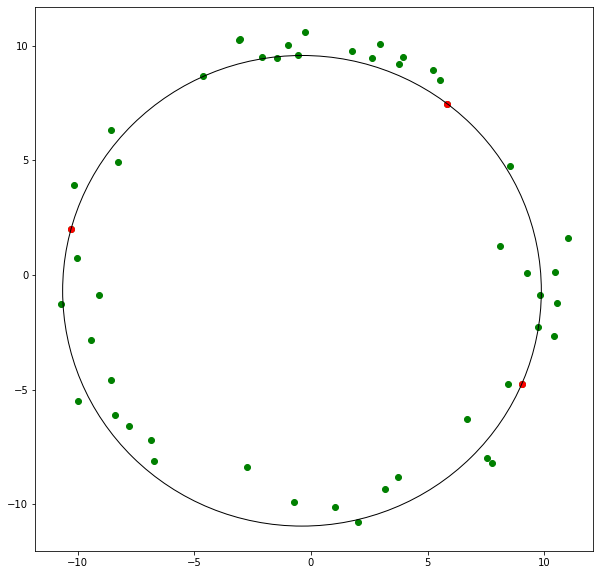

In [10]:
np.random.seed(5)
N = 100
half_n = N // 2
r = 10
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

center, radius, sample, inliers = RANSAC(X_circ, 10000)
fig,ax = plt.subplots(1,1, figsize = (10,10))
circle = plt.Circle(center, radius, fill = False)
ax.scatter(inliers[:,0], inliers[:,1], color = 'green')
ax.add_patch(circle)
ax.scatter(sample[:,0], sample[:,1], color = 'red')
print("Ratio of inliers =",len(inliers)/half_n*100, "%")

for i in range(len(X_circ)):
    if X_circ[i] not in inliers:
        ax.scatter(X_circ[i][0], X_circ[i][1], color = 'blue')

2. Figure 2 shows an architectural image1 with a flag 2
superimposed. This is done by clicking four points on a
planar surface in the architectural image, computing a homography that maps the flag image to this plane,
and warping the flag, and blending on to the architectural image. Carry this out for a couple of image pairs
of you own choice. You may explain the (non-technical) rationale of your choice

[[ 4.94592523e-01  2.97722466e-02 -7.63354488e+01]
 [-7.87029940e-02  3.94505770e-01 -6.87451289e+01]
 [-5.53439239e-04  1.52766181e-04  1.00000000e+00]]


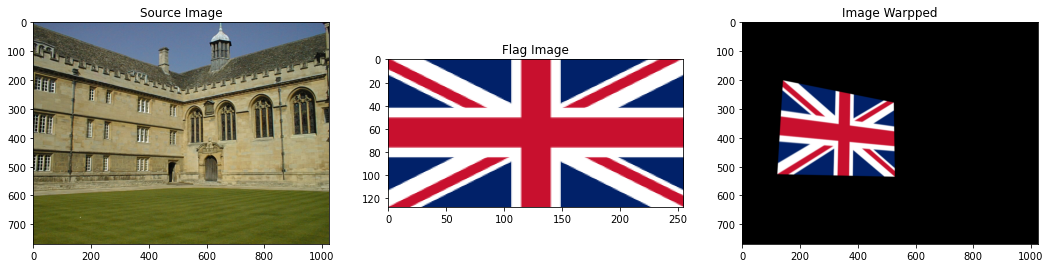

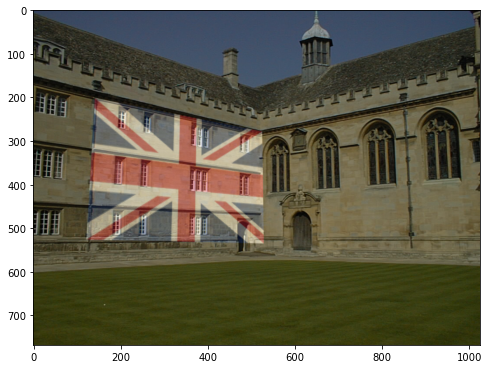

In [12]:
N = 4
global n
n = 0
p = np.empty((N,2))
p_flag = np.empty((N,2))
# mouse callback function
def draw_circle(event,x,y,flags,param):
    global n
    p = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        p[n] = (x,y)
        n += 1

im = cv.imread('images/001.jpg', cv.IMREAD_COLOR)
im_flag = cv.imread('images/Flag_of_the_United_Kingdom.png', cv.IMREAD_COLOR)

im_copy = im.copy()
im_flag_copy = im_flag.copy()

cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [p, im_copy]
cv.setMouseCallback('Image',draw_circle, param)
while(1):
    cv.imshow('Image', im_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break

n = 0
cv.namedWindow('Image Flag', cv.WINDOW_AUTOSIZE)
param = [p_flag, im_flag_copy]
cv.setMouseCallback('Image Flag',draw_circle, param)
while(1):
    cv.imshow('Image Flag', im_flag_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break
cv.destroyAllWindows()

h, status = cv.findHomography(p, p_flag) #Calculating homography between image and flag
print(h)

warped_img = cv.warpPerspective(im_flag, np.linalg.inv(h), (im.shape[1],im.shape[0])) #warping image of flag


fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(cv.cvtColor(im,cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv.cvtColor(im_flag,cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(warped_img,cv.COLOR_BGR2RGB))
ax[2].set_title("Image Warpped")

alpha = 0.65
beta = 1-alpha

blended = cv.addWeighted(im, alpha, warped_img, beta, 0.0)
fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))